# Haqiqi 2021 2a, using pyWBM inputs

## Packages

In [26]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import dask
import os
import glob
import geopandas as gpd
import xagg as xa
from linearmodels.panel import PanelOLS

## Inputs

In [12]:
csv_output_file_haqiqi2021_2a = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/csv_output_file_haqiqi2021_2a_normalgrowingssn_averageseason_averageyearsm.csv"
usda_filepath = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/usda_historical_yields.csv"

In [73]:
fips_level_inputs_pd = pd.read_csv(csv_output_file_haqiqi2021_2a) 
fips_level_inputs_pd = fips_level_inputs_pd.rename(columns={'time': 'year'})
fips_level_inputs_pd['year_input'] = fips_level_inputs_pd['year']
usda_pd = pd.read_csv(usda_filepath)

In [75]:
usda_pd['fips'] = usda_pd['fips'].astype(str).str.zfill(5)
usda_pd['state'] = usda_pd['state'].astype(str).str.zfill(2)
usda_pd = usda_pd[['fips','year','yield', 'state']]

# Count occurrences of 'fips' and name the column 'n'
fips_counts = usda_pd.groupby('fips').size().reset_index(name='n')

# Merge the count back into the original DataFrame
usda_pd = usda_pd.merge(fips_counts, on='fips')
usda_pd = usda_pd[usda_pd["n"] >= 30]

usda_pd['log_yield'] = np.log(usda_pd['yield'])

fips_level_inputs_pd['fips'] = fips_level_inputs_pd['fips'].astype(str).str.zfill(5)
fips_level_inputs_pd['state'] = fips_level_inputs_pd['fips'].astype(str).str.slice(0, 2)

# merge usda_pd & livneh_pd 
df = fips_level_inputs_pd.merge(usda_pd, how='inner', on=['fips', 'year', 'state'])
df['year2'] = df['year']**2

rainfed_states = ["01", "05", "09", "10", "12", "13", "17", "18", "19", "20", 
                   "21", "22", "23", "24", "25", "26", "27", "28", "29", "31", 
                   "33", "34", "36", "37", "38", "39", "40", "42", "44", "45", 
                   "46", "47", "48", "50", "51", "54", "55"]

df = df[df['state'].isin(rainfed_states)]


In [76]:
output_dir = "/storage/home/cta5244/work/avila_et_al_2026_pyWBM_yield/0_uncertainity_figures/1_fips_pywbm_models"
os.makedirs(output_dir, exist_ok=True)
df_set_index = df.set_index(['fips', 'year'])

# define the model with both entity and time fixed effects
model = PanelOLS.from_formula(
    ('log_yield ~ gdd + edd_minus75 + edd_minus25_75 + edd_minus25_plus25 + edd_plus25_75 + edd_plus75 + SoilM_0_100cm + SoilM_0_100cm_square + EntityEffects + TimeEffects'),
    data=df_set_index)

# fit the model
results_h21 = model.fit()

In [77]:
GDD_param = results_h21.params.gdd.item()
EDD_SM_75_below_param = results_h21.params.edd_minus75.item()
EDD_SM_25_75_below_param = results_h21.params.edd_minus25_75.item()
EDD_SM_0_25_norm_param = results_h21.params.edd_minus25_plus25.item()
EDD_SM_25_75_above_param = results_h21.params.edd_plus25_75.item()
EDD_SM_75_above_param = results_h21.params.edd_plus75.item()
SM_mean_param = results_h21.params.SoilM_0_100cm.item()
SM_mean2_param = results_h21.params.SoilM_0_100cm_square.item()

#### Single location model inspection

In [95]:
fips_number = '26139'

entity_effect = results_h21.estimated_effects['estimated_effects'].loc[f'{fips_number}'].values


df_fip_01001 = df[df['fips'] == f'{fips_number}']
model_predication_h21 = (GDD_param * df_fip_01001['gdd'] + 
                     EDD_SM_75_below_param * df_fip_01001['edd_minus75'] + 
                     EDD_SM_25_75_below_param * df_fip_01001['edd_minus25_75'] + 
                     EDD_SM_0_25_norm_param * df_fip_01001['edd_minus25_plus25'] +
                     EDD_SM_25_75_above_param * df_fip_01001['edd_plus25_75'] +
                     EDD_SM_75_above_param * df_fip_01001['edd_plus75'] +
                     SM_mean_param * df_fip_01001['SoilM_0_100cm'] +
                     SM_mean2_param * df_fip_01001['SoilM_0_100cm_square'] +
                    entity_effect)

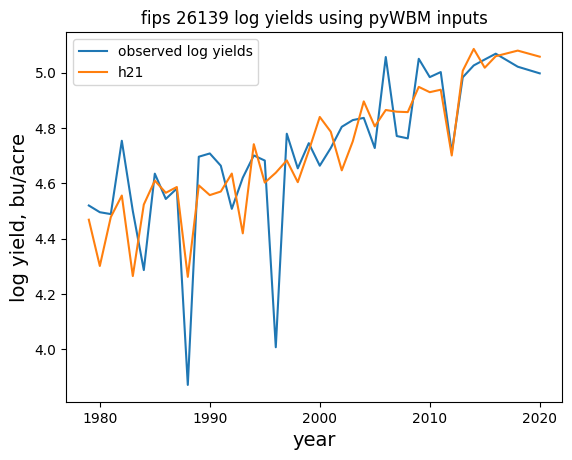

In [79]:
plt.plot(df_fip_01001['year'], df_fip_01001['log_yield'], label='observed log yields')
plt.plot(df_fip_01001['year'],  model_predication_h21, label='h21')
plt.title(f'fips {fips_number} log yields using pyWBM inputs')
plt.ylabel('log yield, bu/acre', fontsize=14)
plt.xlabel('year', fontsize=14)
plt.legend()

### working on pred

In [99]:
model = PanelOLS.from_formula(
    ('log_yield ~ gdd + edd_minus75 + edd_minus25_75 + edd_minus25_plus25 + edd_plus25_75 + edd_plus75 + SoilM_0_100cm + SoilM_0_100cm_square + EntityEffects + TimeEffects'),
    data=df_set_index)

# fit the model
results_h21 = model.fit()
fips_number = '17113'

GDD_param = results_h21.params.gdd.item()
EDD_SM_75_below_param = results_h21.params.edd_minus75.item()
EDD_SM_25_75_below_param = results_h21.params.edd_minus25_75.item()
EDD_SM_0_25_norm_param = results_h21.params.edd_minus25_plus25.item()
EDD_SM_25_75_above_param = results_h21.params.edd_plus25_75.item()
EDD_SM_75_above_param = results_h21.params.edd_plus75.item()
SM_mean_param = results_h21.params.SoilM_0_100cm.item()
SM_mean2_param = results_h21.params.SoilM_0_100cm_square.item()
SM_mean2_param = results_h21.params.SoilM_0_100cm_square.item()
#year_param = results_h21.params.year_input.item()
#year2_param = results_h21.params.year2.item()
entity_effect = results_h21.estimated_effects['estimated_effects'].loc[f'{fips_number}'].values


In [101]:
entity_effect = results_h21.estimated_effects['estimated_effects'].loc[f'{fips_number}'].values


df_fip_01001 = df[df['fips'] == f'{fips_number}']
model_predication_h21 = (GDD_param * df_fip_01001['gdd'] + 
                     EDD_SM_75_below_param * df_fip_01001['edd_minus75'] + 
                     EDD_SM_25_75_below_param * df_fip_01001['edd_minus25_75'] + 
                     EDD_SM_0_25_norm_param * df_fip_01001['edd_minus25_plus25'] +
                     EDD_SM_25_75_above_param * df_fip_01001['edd_plus25_75'] +
                     EDD_SM_75_above_param * df_fip_01001['edd_plus75'] +
                     SM_mean_param * df_fip_01001['SoilM_0_100cm'] +
                     SM_mean2_param * df_fip_01001['SoilM_0_100cm_square'] +
                     entity_effect
                    )

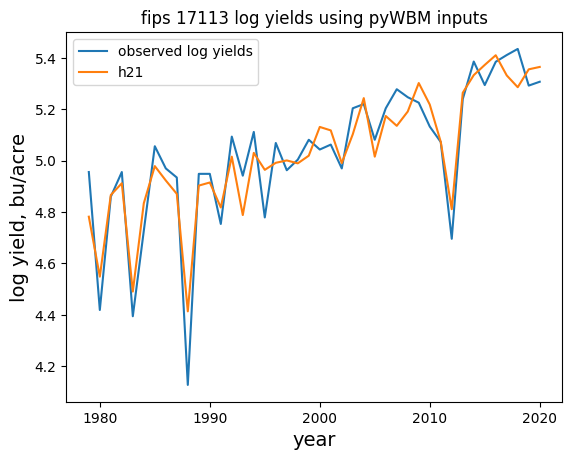

In [102]:
plt.plot(df_fip_01001['year'], df_fip_01001['log_yield'], label='observed log yields')
plt.plot(df_fip_01001['year'],  model_predication_h21, label='h21')
plt.title(f'fips {fips_number} log yields using pyWBM inputs')
plt.ylabel('log yield, bu/acre', fontsize=14)
plt.xlabel('year', fontsize=14)
plt.legend()